# Deeper Dive Into Activations of Our Neural Network

### Introduction

In this notebook, I will take a closer look into the activations of the neural network we just built for generating baby names. The goal of this is to visualize the activations of our neural network and initialize the model parameters better.

## Imports

In [8]:
import random

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [9]:
with open("names.txt") as f:
    words = f.read().splitlines()

chars = set(''.join(words))
chars = sorted(list(chars))

stoi = {char: idx for idx, char in enumerate(chars, start=1)}
itos = {idx: char for idx, char in enumerate(chars, start=1)}
stoi['.'] = 0
itos[0] = '.'

ctx_len = 3

def build_dataset(words):
    X, Y = [], []
    
    for word in words:
        ctx = ['.' for _ in range(ctx_len)]
        word = word + '.'  

        for char in word:
            ctx_tensor = [stoi[char] for char in ctx]
            X.append(ctx_tensor)
            Y.append(stoi[char])
            ctx.pop(0)
            ctx.append(char)
            
    return X, Y

# Create the splits
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)
Xtr, Ytr = build_dataset(words[:n1])
Xva, Yva = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

# print(Xtr.shape, Ytr.shape) # (182625,3), (182625)
print(len(Xtr), len(Xva), len(Xte)) # (182625, 22655, 22866)

182625 22655 22866


## Breaking down the Model 

Instead of using `nn.Linear` that does a lot of other things under the hood, we'll use `nn.Parameter` that just creates trainable tensors (this means we're instantiating the weights and biases for each layer ourselves).

Why?

`nn.Linear` abstracts a lot of things away from us, and we want to be able to see what's going on under the hood. We'll be able to see how the weights and biases change as we train the model.

In [10]:
## Create MLPLMv1 (5 marks)
class MLPLMv1(nn.Module):
    def __init__(self, vocab_size=27, emb_dim=2, ctx_len=3):
        super().__init__()

        #  : Create an embedding layer (same as before)
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        
        #  : Initialize parameters separately using nn.Parameter and torch.randn
        # Note that w1: (emb_dim * ctx_len, 64), b1: (64)
        self.w1 = nn.Parameter(torch.randn(emb_dim * ctx_len, 64))
        self.b1 = nn.Parameter(torch.randn(64))
        self.w2 = nn.Parameter(torch.randn(64, vocab_size))
        self.b2 = nn.Parameter(torch.randn(vocab_size))
    
    def forward(self, x):

        #  : Pass x through the embedding layer and flatten it
        embedded = self.embedding(x)
        x = embedded.view(x.size(0), -1)

        # x: (batch_size, emb_dim * ctx_len)
        #  : Perform the forward pass in steps using matrix multiplication
        # For the non-linearity, use torch.tanh
        x = torch.tanh(torch.mm(x, self.w1) + self.b1)
        logits = torch.mm(x, self.w2) + self.b2
        
        return logits

# Do a forward pass
Xtr = torch.tensor(Xtr)
Xva = torch.tensor(Xva)
Xte = torch.tensor(Xte)
model = MLPLMv1()
out = model(Xtr)
print(out.shape) # (dataset size, vocab size)

torch.Size([182625, 27])


Now we will train and evaluate our model (the losses will do for now) and note the following: 

- The shape of the loss curves

- The final loss values on both the training and validation sets

- The quality of generated names using the current model

In [11]:
#  : Complete the train_model function (same as before, returning a list of losses)
def train_model(model,
                loss_fn,
                optimizer,
                epochs,
                Xtr,
                Ytr):
    # Set model to train mode
    model.train()
    
    # Create a list to store the losses
    losses = []

    for epoch in range(epochs):
        
        optimizer.zero_grad()
        outputs = model(Xtr)
        loss = loss_fn(outputs, Ytr)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    
    # Return the losses for plotting later
    return losses

#  : Complete the evaluate_model function (returning train and val losses)
@torch.no_grad()
def evaluate_model(model,
                   loss_fn,Xtr, Ytr, Xva, Yva):
    # Set model to eval mode
    model.eval()

    train_l = loss_fn(model(Xtr), Ytr)
    val_l = loss_fn(model(Xva), Yva)
    
    return train_l, val_l

# Train and evaluate the model (same as before)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
losses = train_model(model, loss_fn, optimizer,500, Xtr, torch.tensor(Ytr))

# Evaluate the model
train_l, val_l = evaluate_model(model, loss_fn, Xtr, torch.tensor(Ytr), Xva, torch.tensor(Yva))
print(f"Final Train Loss: {train_l:.2f} | Final Validation Loss: {val_l:.2f}")

Final Train Loss: 2.40 | Final Validation Loss: 2.39


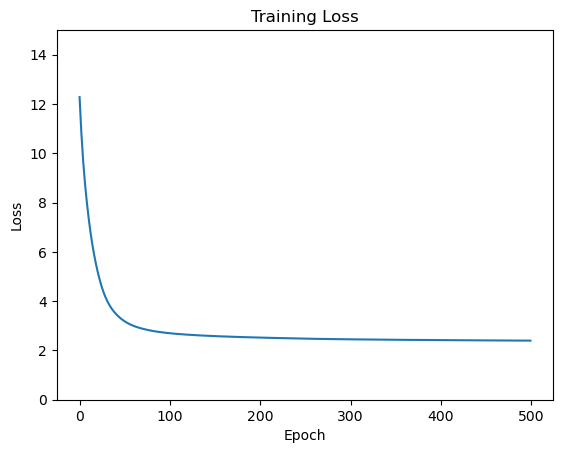

In [12]:
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 15)
plt.show()

In [13]:
#  : Complete the generate_names function (same as before)
def generate_names(model, num_names=20):
    
    for i in range(num_names):
        
        #  : Create a vector of zeros for starters
        ctx = [0, 0, 0]
        gen_name = ''

        # Infinite loop till we get a . character
        while True:

            #  : Convert the context to a tensor
            ctx_tensor = torch.tensor(ctx).unsqueeze(0)

            #  : Pass the context through the model
            logits = model(ctx_tensor)

            #  : Get the probabilities by applying softmax
            probas = torch.softmax(logits, dim=1)

            #  : Sample from the distribution to get the next character (use torch.multinomial)
            idx = torch.multinomial(probas, 1)

            #  : Convert the index to a character
            char = itos[idx.item()]

            # Append the character to the generated name
            gen_name += char

            #  : Update the context
            ctx = ctx[1:] + [idx.item()]

            #  : Break if we get a . character
            if char == '.':  
                break

        print(gen_name)

generate_names(model, num_names=10)

roco.
vidila.
iritenxannlryn.
dhelien.
atanliyah.
a.
ankynni.
zion.
kel.
cakey.


By now, we have noticed the following: 

- The sort of *hockey stick* shape of the loss curves, how it has a very steep drop at the beginning, and then slowly flattens out.

- The final loss values on both the training and validation sets are quite high.

- The quality of generated names using the current model is quite poor.

## Fixing the Initial Loss [10 Marks]

The main reason why we used `nn.Parameter` instead of `nn.Linear` is so that we can initialize the weights and biases ourselves. 

Initialization may sound very simple, but a good strategy is difficult to come up with. There's proof that the model we initialized above is starting off on the wrong foot.

If a model was *truly* randomly initialized, it would be predicting tokens with **equal probability**. How do you know it isn't already doing this?

If we initialized the `nn.Parameter` using `torch.randn`, you likely got an initial loss value of close to `13` (we got `13.88` to start with - if you didn't, you might want to revisit your code).

Now suppose our model actually did predict tokens with equal probability. What would the loss be? The cell below will calculate (what *should* be) the starting value of the loss.

In [14]:
vocab_size = len(stoi)

# Generate dummy label: random integer between 0 and vocab_size
dummy_label = torch.randint(low=0, high=vocab_size, size=(1,))

# Generate uniform logits (all logits are equal -> equal probability for all classes)
logits = torch.zeros(vocab_size)

# Using torch.functional.cross_entropy
loss1 = F.cross_entropy(logits.view(1, -1), dummy_label)
print(loss1)

tensor(3.2958)


Putting it in equations, you should be getting a loss of

$$ \text{Loss} = -\frac{1}{N} \sum_{i=1}^{N} \log \frac{1}{V} = \log V $$

where $N$ is the number of tokens in the dataset, and $V$ is the size of the vocabulary. Try this for yourself in your calculator.

What does this tell us?

Our model starts off on the wrong foot: it *should* be making predictions with equal probability, but it isn't; it's actually performing worse than a model that's randomly guessing (which is a *red flag*). This means that the model is already biased towards some tokens, and is predicting them more often than others.

How do we fix this?

There's three techniques for starters:

1. **Zero out the biases**: Does it really make sense to *randomly initialize* the biases? Why should the model be biased towards some tokens more than others? Zeroing out the biases is a good way to start.

2. **Scaling down the weights**: A good portion of training via gradient descent goes into scaling *down* a portion of the weights, to much smaller values. Why not start off with smaller weights to begin with? This would be as simple as multiplying the weights by a small number (say, `0.01`).

3. **Kaiming Initialization**: This is a more advanced technique so we recommend you read about it [here](https://towardsdatascience.com/understand-kaiming-initialization-and-implementation-detail-in-pytorch-f7aa967e9138).
    
    The short of it is that neural networks have an issue with their activations moving further and further away from a normal Gaussian distribution as we go deeper into the network. When the values follow a normal Gaussian distribution, the gradients are more likely to be of similar magnitude, and thus the weights are updated more evenly (which is desirable). Kaiming initialization is a way to reduce the chances of this *shift* happening. You can read the actual paper for this [here](https://arxiv.org/abs/1502.01852), but this is way beyond the scope of this course.

    If you just want the end result, you can look into [this page](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_) from the PyTorch documentation for the equation, and the table at the top of [this page](https://pytorch.org/docs/stable/nn.init.html#torch-nn-init). 
    
    Since we're using a `tanh` activation, we should scale the weights of the first layer by 
    $$\frac{5}{3\sqrt{\text{emb\_dim}\cdot\text{ctx\_len}}}$$

We will now apply these initialization techniques to your model, and see how they affect the loss curves, with the initial and final loss values after training.

<span style="color: red;">I did not change the model architecture, hyperparameters, or the optimizer. We want to see how the initialization affects the model, so keep everything else the same.</span>

In [15]:
import math 
class MLPLMv2(nn.Module):
    def __init__(self, vocab_size=27, emb_dim=2, ctx_len=3):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, emb_dim)
        
        # Initialize parameters separately, now with the three strategies

        #  : Apply Kaiming initialization to w1
        kaiming_factor = 5/(3*math.sqrt(emb_dim * ctx_len))
        self.w1 = nn.Parameter(torch.randn(emb_dim * ctx_len, 64) * kaiming_factor)
        #  : Zero out the bias
        self.b1 = nn.Parameter(torch.zeros(64))
        #  : Scale w2 by 0.01
        self.w2 = nn.Parameter(torch.randn(64, vocab_size) * 0.01)
        #  : Zero out the bias
        self.b2 = nn.Parameter(torch.zeros(vocab_size))

    def forward(self, x):

        #  : Same as before
        embedded = self.embedding(x)
        x = embedded.view(x.size(0), -1)
        x = torch.tanh(torch.mm(x, self.w1) + self.b1)
        logits = torch.mm(x, self.w2) + self.b2
        
        return logits

# Train and evaluate the new model
model_v2 = MLPLMv2()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_v2.parameters(), lr=0.01)

losses = train_model(model_v2, loss_fn, optimizer,500, Xtr, torch.tensor(Ytr))

# Evaluate the model
train_l, val_l = evaluate_model(model_v2, loss_fn, Xtr, torch.tensor(Ytr), Xva, torch.tensor(Yva))
print(f"Final Train Loss: {train_l:.2f} | Final Validation Loss: {val_l:.2f}")

Final Train Loss: 2.24 | Final Validation Loss: 2.25


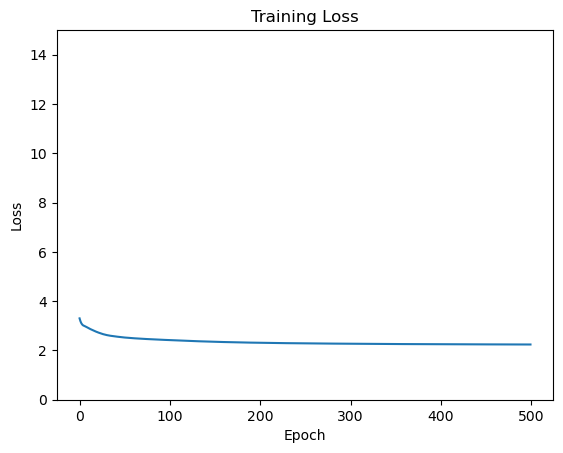

In [16]:
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 15)
plt.show()

In [17]:
generate_names(model, num_names=10)

jar.
zassmyn.
mell.
zdyrta.
mai.
xax.
rainatconienlaelandin.
sonlan.
ricsiun.
masoe.


Now we can observe the following: 

- The initial loss after the initialization should be much closer to the theoretical value we calculated earlier.

- The loss curves should be much smoother, and not have this *hockey stick* shape (that you should realize now was because of the model making redundant corrections to the weights that were fixed by a good initialization).

- The final loss values on both the training and validation sets should be much lower, even though **all we changed** was the initialization scheme.

## Visualizing the Activations 

Lets dissect the model further: some claims were made regarding Gaussian distributions and activations and whatnot. Let's see if they're true.

The main idea is that we'd like the distributions of these activations to be as close to a normal Gaussian distribution as possible. This is because the gradients are more likely to be of similar magnitude, and thus the weights are updated more evenly (which is desirable). 

One aspect of this is that the standard deviation of the distribution should be close to `1`. We'll be plotting the the activations of a linear layer, and computing their standard deviation. We find that the Kaiming Initialization scheme will always be better than a random one, since the activations are closer to a normal Gaussian distribution (just note the std for both).

In [18]:
fan_in = 100 # the number of hidden units
kaiming_factor = fan_in ** 0.5 # since we don't have an activation func

Mean of x: -0.0029 | Std of x: 1.0006
Mean of h: -0.0011 | Std of h: 0.9595


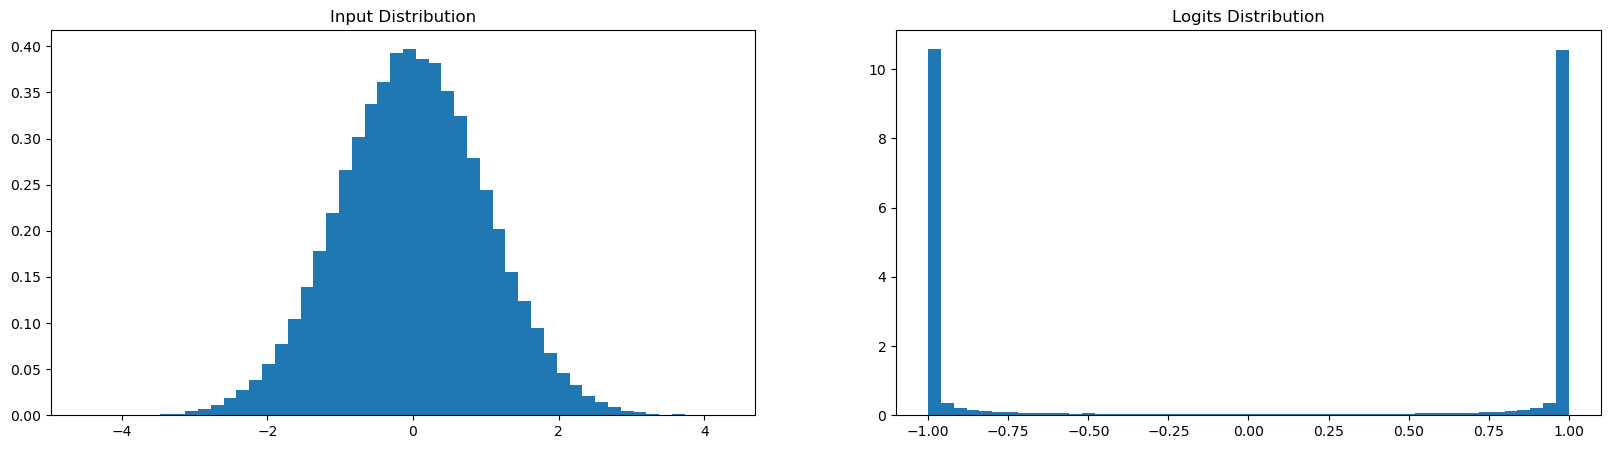

In [19]:
## Distribution WITHOUT Kaiming Initialization
x = torch.randn(1000, fan_in)
w = torch.randn(fan_in, 200)
h = torch.tanh(x @ w)

print(f"Mean of x: {x.mean().item():.4f} | Std of x: {x.std().item():.4f}")
print(f"Mean of h: {h.mean().item():.4f} | Std of h: {h.std().item():.4f}")

# Plot the distributions of input and logits
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.title('Input Distribution')
plt.hist(x.view(-1).tolist(), 50, density=True, label='x')
plt.subplot(122)
plt.title('Logits Distribution')
plt.hist(h.view(-1).tolist(), 50, density=True, label='y')
plt.show()

Mean of x: -0.0008 | Std of x: 1.0046
Mean of h: -0.0038 | Std of h: 0.9962


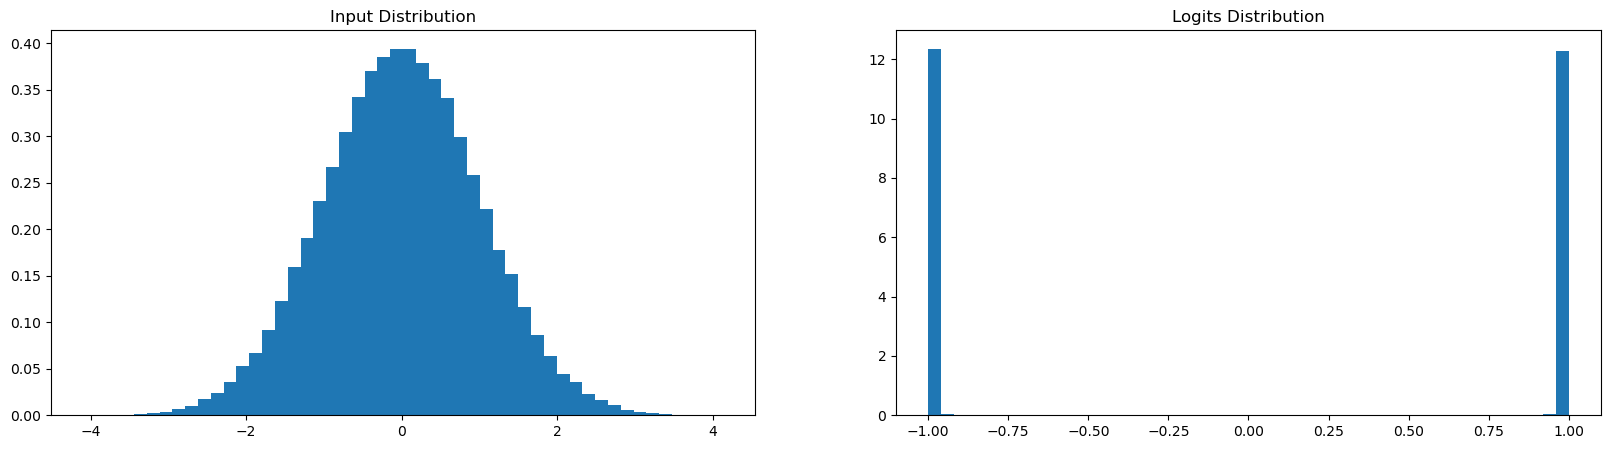

In [20]:
## Distribution WITH Kaiming Initialization
x = torch.randn(1000, fan_in)
w = torch.randn(fan_in, 200) * kaiming_factor
h = torch.tanh(x @ w)

print(f"Mean of x: {x.mean().item():.4f} | Std of x: {x.std().item():.4f}")
print(f"Mean of h: {h.mean().item():.4f} | Std of h: {h.std().item():.4f}")

# Plot the distributions of input and logits
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.title('Input Distribution')
plt.hist(x.view(-1).tolist(), 50, density=True, label='x')
plt.subplot(122)
plt.title('Logits Distribution')
plt.hist(h.view(-1).tolist(), 50, density=True, label='y')
plt.show()

### With our Trained Model

We'll be using the model we trained earlier, and plotting the activations of the first linear layer. We'll be using the `forward` method of the model to get the activations.

In [21]:
model.eval()

# Get the weights
w1 = model.w1.detach()
b1 = model.b1.detach()
w2 = model.w2.detach()
b2 = model.b2.detach()

# Get the first 1000 examples from the training set and get the activations
Xmb = Xtr[:1000]

with torch.no_grad():
    x = model.embedding(Xmb)
    x = x.view(x.shape[0], -1)
    z = x @ w1 + b1
    h = torch.tanh(z)
    logits = h @ w2 + b2    

Note that the upcoming analysis is based on the `tanh` activation function, and assumes you trained the model correctly in the previous section.

There are three graphs to take note of:

1. The **histogram of the activations** (after `tanh`). Note how the high bars imply the values *saturate* around that point.

2. The **matrix** of locations where the activations (after `tanh`) are *very close* to 1 (also implying saturation).

3. The **histogram of probabilities** - since the model is trained, there should be peaks corresponding to the tokens that are more likely to be predicted (that the model is more confident about).

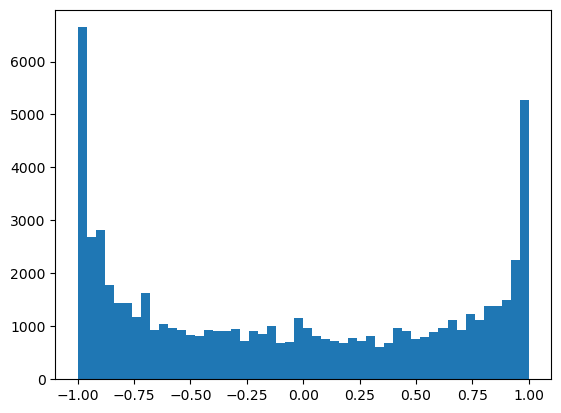

In [22]:
# Plot the distribution of the logits
plt.hist(h.view(-1).tolist(), 50)
plt.show()

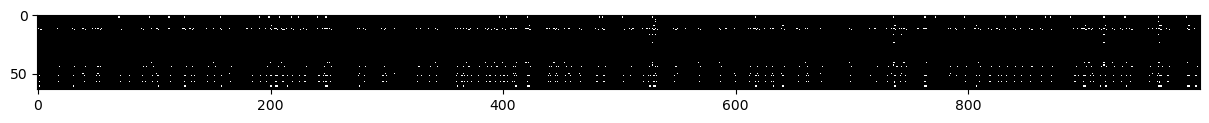

In [23]:
plt.figure(figsize=(15,15))
plt.imshow(h.T.abs() > 0.9999, cmap='gray', interpolation='nearest')
plt.show()

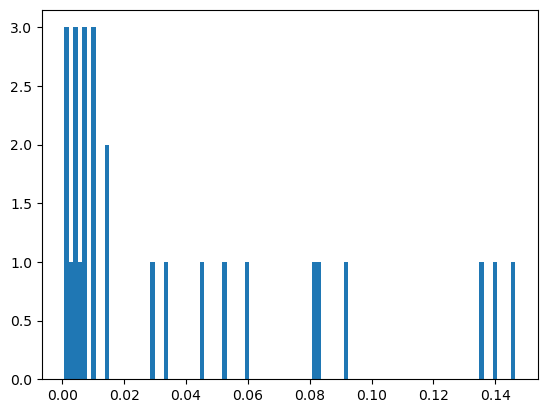

In [24]:
ind = random.choice(range(len(logits)))
probas = F.softmax(logits[ind], dim=0)
plt.hist(probas, bins=100)
plt.show()

### With Poorly Initialized Weights

We can explore the same graphs with the poorly initialized weights. You should see some stark differences.

In [25]:
# Get the weights
w1 = torch.randn(6, 64)
b1 = torch.randn(64)
w2 = torch.randn(64, 27)
b2 = torch.randn(27)

Xmb = Xtr[:1000]

with torch.no_grad():
    x = model.embedding(Xmb)
    x = x.view(x.shape[0], -1)
    z = x @ w1 + b1
    h = torch.tanh(z)
    logits = h @ w2 + b2

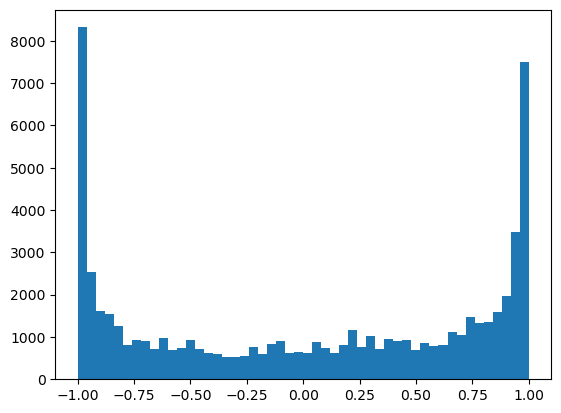

In [26]:
plt.hist(h.view(-1).tolist(), 50)
plt.show()

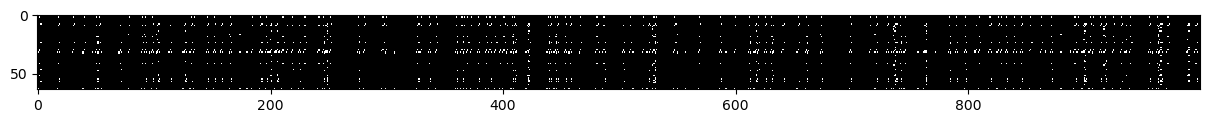

In [27]:
plt.figure(figsize=(15,15))
plt.imshow(h.T.abs() > 0.9999, cmap='gray', interpolation='nearest')
plt.show()

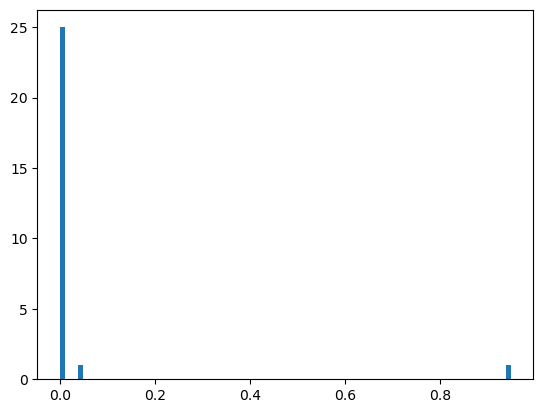

In [28]:
ind = random.choice(range(len(logits)))
probas = F.softmax(logits[ind], dim=0)
plt.hist(probas, bins=100)
plt.show()